In [1]:
# If you're running on a shared cluster and want to limit the resources you take up:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NPROC'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)

import jax_tqdm
import numpyro
import equinox
import optax
import paramax
from flowjax.distributions import StandardNormal, Transformed
from flowjax.bijections import \
    RationalQuadraticSpline, Affine, Sigmoid, Chain, EmbedCondition
from flowjax.flows import block_neural_autoregressive_flow, coupling_flow

In [3]:
# tapering functions

def cubic_filter(x):
    return (3 - 2 * x) * x**2 * (0 <= x) * (x <= 1) + (1 < x)

def highpass(x, xmin, dmin):
    return cubic_filter((x - xmin) / dmin)

def lowpass(x, xmax, dmax):
    return highpass(x, xmax, -dmax)

def bandpass(x, xmin, xmax, dmin, dmax):
    return highpass(x, xmin, dmin) * lowpass(x, xmax, dmax)

In [184]:
# power law functions

def truncated_powerlaw(x, alpha, xmin, xmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = x**alpha
    norm = (xmax**(alpha + 1) - xmin**(alpha + 1)) / (alpha + 1)
    return cut * shape / norm

def powerlaw_integral(x, alpha, loc, delta):
    a, c, d = alpha, loc, delta
    return (
        3 * (2 * c + (4 + a) * d)
        * (c**2 / (1 + a) - 2 * c * x / (2 + a) + x**2 / (3 + a))
        - 2 * (x - c)**3
    ) * x**(1 + a) / (4 + a) / d**3

def highpass_truncated_powerlaw(x, alpha, xmin, xmax, dmin):
    cut = (xmin <= x) * (x <= xmax)
    shape = x**alpha * highpass(x, xmin, dmin)
    norm = (
        - powerlaw_integral(xmin, alpha, xmin, dmin)
        + powerlaw_integral(xmin + dmin, alpha, xmin, dmin)
        - (xmin + dmin)**(alpha + 1) / (alpha + 1)
        + xmax**(alpha + 1) / (alpha + 1)
    )
    return cut * shape / norm

def bandpass_powerlaw(x, alpha, xmin, xmax, dmin, dmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = x**alpha * bandpass(x, xmin, xmax, dmin, dmax)
    norm = (
        - powerlaw_integral(xmin, alpha, xmin, dmin)
        + powerlaw_integral(xmin + dmin, alpha, xmin, dmin)
        - (xmin + dmin)**(alpha + 1) / (alpha + 1)
        + (xmax - dmax)**(alpha + 1) / (alpha + 1)
        - powerlaw_integral(xmax - dmax, alpha, xmax, -dmax)
        + powerlaw_integral(xmax, alpha, xmax, -dmax)
    )
    return cut * shape / norm

In [185]:
# Gaussian functions

def truncated_normal(x, mu, sigma, xmin, xmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = jax.scipy.stats.norm.pdf(x, mu, sigma)
    norm = (
        - jax.scipy.stats.norm.cdf(xmin, mu, sigma)
        + jax.scipy.stats.norm.cdf(xmax, mu, sigma)
    )
    return cut * shape / norm

def normal_integral(x, mu, sigma, loc, delta):
    m, s, c, d = mu, sigma, loc, delta
    return (
        jnp.exp(-(x - m)**2 / 2 / s ** 2) * (2 / jnp.pi)**0.5 * s * (
            6 * c * (c + d - m - x)
            - 3 * d * (m + x)
            + 2 * (m**2 + 2 * s**2 + m * x + x**2)
        )
        - jax.lax.erf((m - x) / s / 2**0.5) * (
            (2 * c + 3 * d - 2 * m) * (c - m)**2
            + 3 * s**2 * (2 * c + d - 2 * m)
        )
    ) / 2 / d**3

def highpass_truncated_normal(x, mu, sigma, xmin, xmax, dmin):
    cut = (xmin <= x) * (x <= xmax)
    shape = jax.scipy.stats.norm.pdf(x, mu, sigma) * highpass(x, xmin, dmin)
    norm = (
        - normal_integral(xmin, mu, sigma, xmin, dmin)
        + normal_integral(xmin + dmin, mu, sigma, xmin, dmin)
        - jax.scipy.stats.norm.cdf(xmin + dmin, mu, sigma)
        + jax.scipy.stats.norm.cdf(xmax, mu, sigma)
    )
    return cut * shape / norm

def bandpass_normal(x, mu, sigma, xmin, xmax, dmin, dmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = (
        jax.scipy.stats.norm.pdf(x, mu, sigma)
        * bandpass(x, xmin, xmax, dmin, dmax)
    )
    norm = (
        - normal_integral(xmin, mu, sigma, xmin, dmin)
        + normal_integral(xmin + dmin, mu, sigma, xmin, dmin)
        - jax.scipy.stats.norm.cdf(xmin + dmin, mu, sigma)
        + jax.scipy.stats.norm.cdf(xmax - dmax, mu, sigma)
        - normal_integral(xmax - dmax, mu, sigma, xmax, -dmax)
        + normal_integral(xmax, mu, sigma, xmax, -dmax)
    )
    return cut * shape / norm

In [384]:
# def pdf_m(m, parameters):
#     pl = bandpass_powerlaw(
#         m,
#         parameters['alpha'],
#         parameters['m_min'],
#         parameters['m_max'],
#         parameters['d_min'],
#         parameters['d_max'],
#     )
#     tn = bandpass_normal(
#         m,
#         parameters['mu_m'],
#         parameters['sigma_m'],
#         parameters['m_min'],
#         parameters['m_max'],
#         parameters['d_min'],
#         parameters['d_max'],
#     )
#     return (1 - parameters['f_m']) * pl + parameters['f_m'] * tn

def maximum_mass(parameters):
    return parameters['mu_m'] + parameters['sigma_m'] * 3

def pdf_m(m, parameters):
    pl = bandpass_powerlaw(
        m,
        parameters['alpha'],
        parameters['m_min'],
        maximum_mass(parameters),
        parameters['d_min'],
        parameters['sigma_m'] * 3,
    )
    tn = bandpass_normal(
        m,
        parameters['mu_m'],
        parameters['sigma_m'],
        parameters['m_min'],
        maximum_mass(parameters),
        parameters['d_min'],
        parameters['sigma_m'] * 3,
    )
    return (1 - parameters['f_m']) * pl + parameters['f_m'] * tn

Array(0.9999996, dtype=float64)

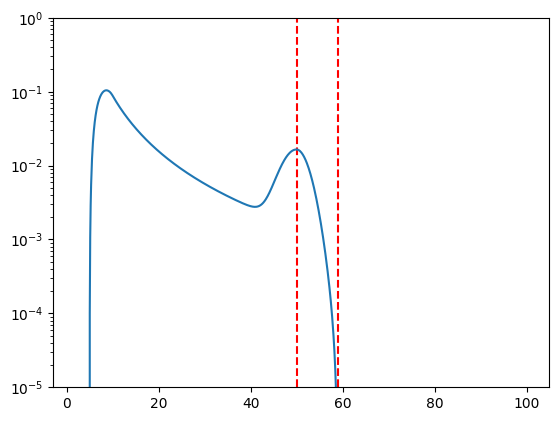

In [410]:
m = jnp.linspace(2, 100, 1_000)
parameters = dict(
    alpha = -2.5,
    m_min = 5,
    d_min = 5,
    mu_m = 50,
    sigma_m = 3,
    f_m = 0.1,
)
p = pdf_m(m, parameters)
plt.axvline(parameters['mu_m'], c = 'r', ls = '--')
plt.axvline(maximum_mass(parameters), c = 'r', ls = '--')
plt.plot(m, p)
plt.semilogy()
plt.ylim(1e-5, 1e0)
jnp.trapezoid(p, m)

In [409]:
def eval_eta(q):
    return q / (1 + q)**2

def eval_theta12(theta1, theta2, deltaphi):
    return jnp.arccos(
        jnp.sin(theta1) * jnp.sin(theta2) * jnp.cos(deltaphi)
        + jnp.cos(theta1) * jnp.cos(theta2)
    )

def angles_to_Lframe(theta1, theta2, deltaphi, r, q, chi1, chi2):
    L = r**0.5 * q / (1 + q)**2
    S1 = chi1 / (1 + q)**2
    S2 = chi2 * q**2 / (1 + q)**2

    Lx = 0
    Ly = 0
    Lz = L
    Lvec = jnp.array([Lx, Ly, Lz])

    S1x = S1 * jnp.sin(theta1)
    S1y = 0
    S1z = S1 * jnp.cos(theta1)
    S1vec = jnp.array([S1x, S1y, S1z])

    S2x = S2 * jnp.sin(theta2) * jnp.cos(deltaphi)
    S2y = S2 * jnp.sin(theta2) * jnp.sin(deltaphi)
    S2z = S2 * jnp.cos(theta2)
    S2vec = jnp.array([S2x, S2y, S2z])

    return Lvec, S1vec, S2vec

In [387]:
def remnant_mass(theta1, theta2, q, chi1, chi2):
    eta = eval_eta(q)

    chit_par =  ( chi2*q**2 * jnp.cos(theta2) + chi1*jnp.cos(theta1) ) / (1+q)**2

    #Final mass. Barausse Morozova Rezzolla 2012
    p0 = 0.04827
    p1 = 0.01707
    Z1 = 1 + (1-chit_par**2)**(1/3)* ((1+chit_par)**(1/3)+(1-chit_par)**(1/3))
    Z2 = (3* chit_par**2 + Z1**2)**(1/2)
    risco = 3 + Z2 - jnp.sign(chit_par) * ((3-Z1)*(3+Z1+2*Z2))**(1/2)
    Eisco = (1-2/(3*risco))**(1/2)
    #Radiated energy, in units of the initial total mass of the binary
    Erad = eta*(1-Eisco) + 4* eta**2 * (4*p0+16*p1*chit_par*(chit_par+1)+Eisco-1)
    Mfin = 1- Erad # Final mass

    return Mfin

In [388]:
def remnant_spin(theta1, theta2, deltaphi, q, chi1, chi2):
    eta = eval_eta(q)

    kfit = jnp.array( [[jnp.nan, 3.39221, 4.48865, -5.77101, -13.0459] ,
                      [35.1278, -72.9336, -86.0036, 93.7371, 200.975],
                      [-146.822, 387.184, 447.009, -467.383, -884.339],
                      [223.911, -648.502, -697.177, 753.738, 1166.89]])
    xifit = 0.474046

    # Calculate K00 from Eq 11
    kfit = kfit.at[0,0].set(4**2 * ( 0.68646 - jnp.sum( kfit[1:,0] /(4**(3+jnp.arange(kfit.shape[0]-1)))) - (3**0.5)/2))

    theta12 = eval_theta12(theta1, theta2, deltaphi)

    eps1 = 0.024
    eps2 = 0.024
    eps12 = 0
    theta1 = theta1 + eps1 * jnp.sin(theta1)
    theta2 = theta2 + eps2 * jnp.sin(theta2)
    theta12 = theta12 + eps12 * jnp.sin(theta12)

    # Eq. 14 - 15
    atot = ( chi1*jnp.cos(theta1) + chi2*jnp.cos(theta2)*q**2 ) / (1+q)**2
    aeff = atot + xifit*eta* ( chi1*jnp.cos(theta1) + chi2*jnp.cos(theta2) )

    # Eq. 2 - 6 evaluated at aeff, as specified in Eq. 11
    Z1= 1 + (1-(aeff**2))**(1/3) * ( (1+aeff)**(1/3) + (1-aeff)**(1/3) )
    Z2= ( (3*aeff**2) + (Z1**2) )**(1/2)
    risco= 3 + Z2 - jnp.sign(aeff) * ( (3-Z1)*(3+Z1+2*Z2) )**(1/2)
    Eisco=(1-2/(3*risco))**(1/2)
    Lisco = (2/(3*(3**(1/2)))) * ( 1 + 2*(3*risco - 2 )**(1/2) )

    # Eq. 13
    etatoi = eta**(1+jnp.arange(kfit.shape[0]))
    innersum = jnp.sum(kfit.T * etatoi,axis=1)
    aefftoj = aeff**(jnp.arange(kfit.shape[1]))
    sumell = jnp.sum(innersum  * aefftoj,axis=0)
    ell = jnp.abs( Lisco  - 2*atot*(Eisco-1)  + sumell )

    # Eq. 16
    chifin = (1/(1+q)**2) * ( chi1**2 + (chi2**2)*(q**4)  + 2*chi1*chi2*(q**2)*jnp.cos(theta12)
            + 2*(chi1*jnp.cos(theta1) + chi2*(q**2)*jnp.cos(theta2))*ell*q + ((ell*q)**2)  )**(1/2)

    return jnp.minimum(chifin,1)

In [389]:
def remnant_kick(bigTheta, theta1, theta2, deltaphi, q, chi1, chi2):
# kms=False, maxphase=False, superkick=True, hangupkick=True, crosskick=True, full_output=False):

    eta = eval_eta(q)

    Lvec, S1vec, S2vec = angles_to_Lframe(theta1, theta2, deltaphi, 1, q, chi1, chi2)
    hatL = Lvec / jnp.linalg.norm(Lvec)
    hatS1 = S1vec / jnp.linalg.norm(S1vec)
    hatS2 = S2vec / jnp.linalg.norm(S2vec)

    #More spin parameters.
    Delta = - 1/(1+q) * (q*chi2*hatS2 - chi1*hatS1)
    Delta_par = jnp.dot(Delta, hatL)
    Delta_perp = jnp.linalg.norm(jnp.cross(Delta, hatL))
    chit = 1/(1+q)**2 * (chi2*q**2*hatS2 + chi1*hatS1)
    chit_par = jnp.dot(chit, hatL)
    chit_perp = jnp.linalg.norm(jnp.cross(chit, hatL))

    #Coefficients are quoted in km/s
    #vm and vperp from Kesden at 2010a. vpar from Lousto Zlochower 2013
    zeta=jnp.radians(145)
    A=1.2e4
    B=-0.93
    H=6.9e3

    #Multiply by 0/1 boolean flags to select terms
    V11 = 3677.76
    VA = 2481.21
    VB = 1792.45
    VC = 1506.52
    C2 = 1140
    C3 = 2481

    # #maxkick
    # bigTheta=np.random.uniform(0, 2*np.pi,q.shape) * (not maxphase)

    vm = A * eta**2 * (1+B*eta) * (1-q)/(1+q)
    vperp = H * eta**2 * Delta_par
    vpar = 16*eta**2 * (Delta_perp * (V11 + 2*VA*chit_par + 4*VB*chit_par**2 + 8*VC*chit_par**3) + chit_perp * Delta_par * (2*C2 + 4*C3*chit_par)) * jnp.cos(bigTheta)
    kick = jnp.array([vm+vperp*jnp.cos(zeta),vperp*jnp.sin(zeta),vpar]).T

    # if not kms:
    #     kick = kick/299792.458 # speed of light in km/s

    vk = jnp.linalg.norm(kick)

    return vk

In [391]:
def inversion_sampling(key, shape, pdf, x):
    cdf = jnp.cumsum(jnp.diff(x) * (pdf[1:] + pdf[:-1]) / 2)
    cdf = jnp.insert(cdf / cdf[-1], 0, 0)
    u = jax.random.uniform(key, shape)
    return jnp.interp(u, cdf, x)

def sample_m(key, shape, parameters):
    x = jnp.linspace(parameters['m_min'], maximum_mass(parameters), 1_000)
    p = pdf_m(x, parameters)
    return inversion_sampling(key, shape, p, x)

def sample_truncated_normal(key, shape, mu, sigma, lo, hi):
    u = jax.random.uniform(key, shape)
    loc = jax.scipy.stats.norm.cdf(lo, mu, sigma)
    scale = jax.scipy.stats.norm.cdf(hi, mu, sigma) - loc
    return jax.scipy.stats.norm.ppf(u * scale + loc, mu, sigma)

In [392]:
def sample_1g(key, n, parameters):
    # masses
    key, subkey = jax.random.split(key)
    m = sample_m(subkey, (2, n), parameters)
    m1, m2 = m.max(axis = 0), m.min(axis = 0)
    q = m2 / m1

    # spin magnitudes
    key, subkey = jax.random.split(key)
    a1, a2 = sample_truncated_normal(
        subkey, (2, n), parameters['mu_a'], parameters['sigma_a'], 0, 1,
    )

    # spin tilts
    key, subkey = jax.random.split(key)
    c1, c2 = jax.random.uniform(subkey, (2, n), minval = -1, maxval = 1)

    # azimuthal angle
    key, subkey = jax.random.split(key)
    dp = jax.random.uniform(subkey, (n,), minval = 0, maxval = 2 * jnp.pi)

    # pairing function
    pair = (m1 + m2)**parameters['beta']
    key, subkey = jax.random.split(key)
    idxs = jax.random.choice(subkey, n, shape = (n,), p = pair)
    mergers = jnp.array([m1, q, a1, a2, c1, c2, dp])[:, idxs]

    return mergers

In [393]:
def remnant(m1, q, a1, a2, c1, c2, dp, th):
    t1, t2 = jnp.arccos(c1), jnp.arccos(c2)
    mf = remnant_mass(t1, t2, q, a1, a2) * m1 * (1 + q)
    af = remnant_spin(t1, t2, dp, q, a1, a2)
    vf = remnant_kick(th, t1, t2, dp, q, a1, a2)
    return mf, af, vf

In [394]:
def sample_2g(key, mf, af, vf, parameters):
    n = jnp.array([mf, af, vf]).shape[1]

    # 1g mass
    key, subkey = jax.random.split(key)
    m = sample_m(subkey, (n,), parameters)

    # ejection and pairing
    key, subkey = jax.random.split(key)
    pair = (vf < parameters['v_esc']) * (mf + m)**parameters['gamma']
    idxs = jax.random.choice(subkey, n, shape = (n,), p = pair)

    # masses
    m_2g = jnp.stack([mf, m])
    sort = jnp.argsort(m_2g, axis = 0)
    m2_2g, m1_2g = jnp.take_along_axis(m_2g, sort, axis = 0)
    q_2g = m2_2g / m1_2g

    # spin magnitudes
    key, subkey = jax.random.split(key)
    a = sample_truncated_normal(
        subkey, (n,), parameters['mu_a'], parameters['sigma_a'], 0, 1,
    )
    a2_2g, a1_2g = jnp.take_along_axis(jnp.stack([af, a]), sort, axis = 0)

    # spin tilts
    key, subkey = jax.random.split(key)
    c1_2g, c2_2g = jax.random.uniform(subkey, (2, n), minval = -1, maxval = 1)

    # azimuthal spin
    key, subkey = jax.random.split(key)
    dp_2g = jax.random.uniform(subkey, (n,), minval = 0, maxval = 2 * jnp.pi)

    mergers = jnp.array([m1_2g, q_2g, a1_2g, a2_2g, c1_2g, c2_2g, dp_2g])

    return mergers

In [395]:
def sample_mergers(key, n, parameters):
    # 1g+1g mergers
    key, subkey = jax.random.split(key)
    mergers = sample_1g(subkey, n, parameters)

    # 1g+1g remnants (2g)
    key, subkey = jax.random.split(key)
    th = jax.random.uniform(subkey, (n,), minval = 0, maxval = 2 * jnp.pi)
    mf, af, vf = jax.vmap(remnant)(*mergers, th)

    # 1g+2g mergers
    key, subkey = jax.random.split(key)
    mergers_2g = sample_2g(subkey, mf, af, vf, parameters)

    # mixing
    key, subkey = jax.random.split(key)
    f = (vf < parameters['v_esc']) * parameters['r_2g']
    b = jax.random.binomial(subkey, n = 1, p = f, shape = (n,))
    mergers = jnp.where(b, mergers_2g, mergers)

    # we'll just fit masses and spin magnitudes as the other angles are
    # mostly independent
    return mergers[:4].T

In [414]:
parameters = dict(
    alpha = -2.5,
    m_min = 5,
    d_min = 5,
    mu_m = 35,
    sigma_m = 3,
    f_m = 0.1,
    beta = 0,
    mu_a = 0.1,
    sigma_a = 0.2,
    v_esc = 1_000,
    gamma = 0,
    r_2g = 0.1,
)

In [415]:
mergers = sample_mergers(jax.random.key(0), 100_000, parameters)

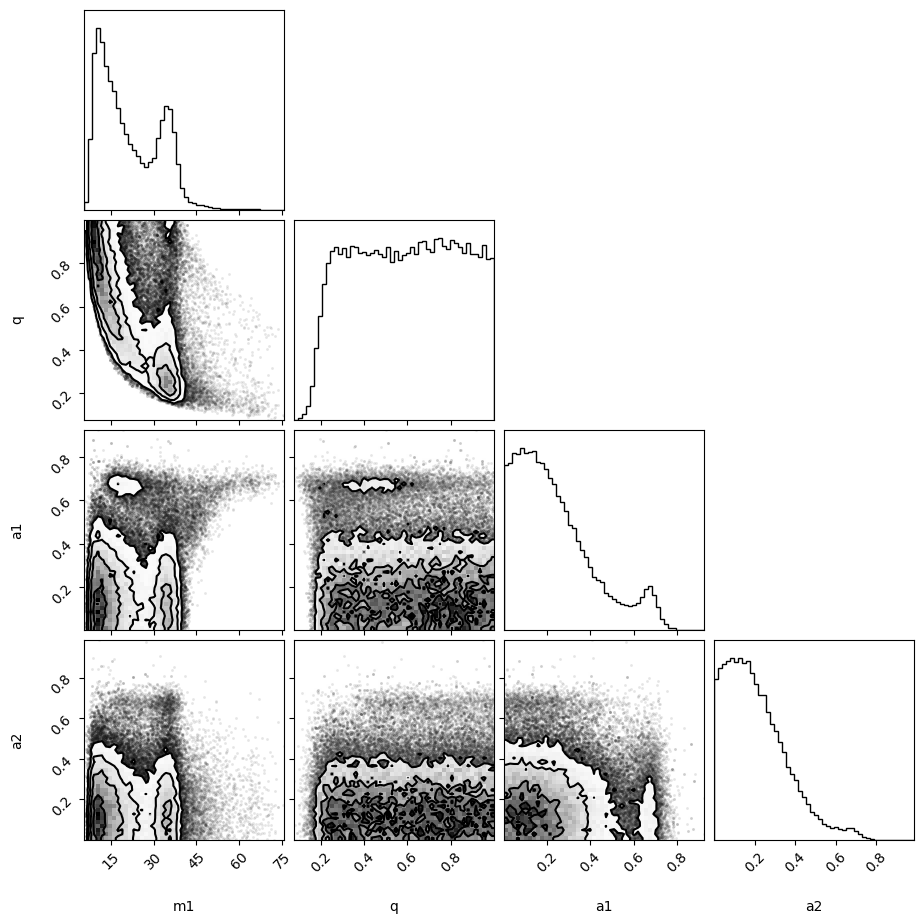

In [416]:
fig = corner(np.array(mergers), bins = 50, labels = ('m1', 'q', 'a1', 'a2'));

In [418]:
priors = dict(
    alpha = numpyro.distributions.Uniform(-5, 5),
    m_min = numpyro.distributions.Uniform(2, 10),
    d_min = numpyro.distributions.Uniform(0, 10),
    mu_m = numpyro.distributions.Uniform(20, 60),
    sigma_m = numpyro.distributions.Uniform(1, 5),
    f_m = numpyro.distributions.Uniform(0, 0.2),
    beta = numpyro.distributions.Uniform(-5, 5),
    mu_a = numpyro.distributions.Uniform(0, 0.5),
    sigma_a = numpyro.distributions.Uniform(0.1, 0.5),
    v_esc = numpyro.distributions.Uniform(0, 1_000),
    gamma = numpyro.distributions.Uniform(-5, 5),
    r_2g = numpyro.distributions.Uniform(0, 1),
)

In [419]:
def sample_parameters(key):
    keys = jax.random.split(key, len(priors))
    return {k: priors[k].sample(key) for k, key in zip(priors, keys)}

In [420]:
def inverse_parameters(parameters):
    x = jnp.array([
        (parameters[k] - priors[k].low) / (priors[k].high - priors[k].low)
        for k in priors
    ])
    x = jnp.clip(x, 1e-3, 1 - 1e-3)
    x = jax.scipy.stats.norm.ppf(x)
    return x

In [421]:
dim = 4
lo = jnp.array([2, 0, 0, 0])
hi = jnp.array([200, 1, 1, 1])

def inverse_mergers(mergers):
    x = (mergers - lo) / (hi - lo)
    x = jnp.clip(x, 1e-3, 1 - 1e-3)
    return jax.scipy.special.logit(x)

def forward_mergers(x):
    return jax.nn.sigmoid(x) * (hi - lo) + lo

In [466]:
flow_init = block_neural_autoregressive_flow(
    key = jax.random.key(1),
    base_dist = StandardNormal(shape = (dim,)),
    cond_dim = len(priors),
    invert = True,
    nn_depth = 1,
    nn_block_dim = 20,
    flow_layers = 1,
)

# flow_init = coupling_flow(
#     key = jax.random.key(1),
#     base_dist = StandardNormal(shape = (lo.size,)),
#     cond_dim = len(priors),
#     transformer = RationalQuadraticSpline(
#         knots = 5, interval = 5, # min_derivative = 0, softmax_adjust = 0,
#     ),
#     flow_layers = 3,
#     nn_width = 10,
#     nn_depth = 1,
#     nn_activation = jax.nn.elu,
#     invert = True,
# )

params_init, static = equinox.partition(flow_init, equinox.is_inexact_array)
array_init, unflatten = jax.flatten_util.ravel_pytree(params_init)
array_init.size

1768

In [476]:
batch_size = 1_000
steps = 30_000
learning_rate = 1e-2
learning_rate = optax.cosine_decay_schedule(learning_rate, steps)
optimizer = optax.adam(learning_rate)
# decay = optax.contrib.reduce_on_plateau(
#     factor = 0.5,
#     patience = 1_000,
#     rtol = 1e-4,
#     atol = 0,
#     cooldown = 0,
#     accumulation_size = 1,
#     min_scale = 0,
# )
# optimizer = optax.chain(optimizer, decay)

In [477]:
def sample(key):
    key, subkey = jax.random.split(key)
    parameters = sample_parameters(subkey)
    c = inverse_parameters(parameters)
    key, subkey = jax.random.split(key)
    mergers = sample_mergers(subkey, batch_size, parameters)
    x = inverse_mergers(mergers)
    return x, c

def loss_fn(params, key):
    flow = equinox.combine(params, static)
    x, c = sample(key)
    return -flow.log_prob(x, c).mean()

In [478]:
def check_finite(carry, loss):
    key, params, state, best_params, best_state, best_loss = carry
    params, state = jax.lax.cond(
        jnp.isfinite(loss),
        lambda: (params, state),
        lambda: (best_params, best_state),
    )
    return key, params, state, best_params, best_state, best_loss

def check_best(carry, loss):
    key, params, state, best_params, best_state, best_loss = carry
    best_params, best_state, best_loss = jax.lax.cond(
        loss < best_loss,
        lambda: (params, state, loss),
        lambda: (best_params, best_state, best_loss),
    )
    return key, params, state, best_params, best_state, best_loss

@jax_tqdm.scan_tqdm(steps, print_rate = 100, tqdm_type = 'std')
def update(carry, step):
    key, params, state, best_params, best_state, best_loss = carry
    key, _key = jax.random.split(key)
    loss, grad = equinox.filter_value_and_grad(loss_fn)(params, _key)
    updates, state = optimizer.update(grad, state, params, value = loss)
    params = equinox.apply_updates(params, updates)
    carry = key, params, state, best_params, best_state, best_loss
    carry = check_finite(carry, loss)
    carry = check_best(carry, loss)
    return carry, loss

In [479]:
state = optimizer.init(params_init)
carry = (
    jax.random.key(100),
    params_init,
    state,
    params_init,
    state,
    jnp.inf,
)
carry, losses = jax.lax.scan(update, carry, jnp.arange(steps))
key, params, state, best_params, best_state, best_loss = carry

Running for 30,000 iterations: 100%|█████████████████████████████████████████████████████████████████████| 30000/30000 [01:04<00:00, 464.09it/s]


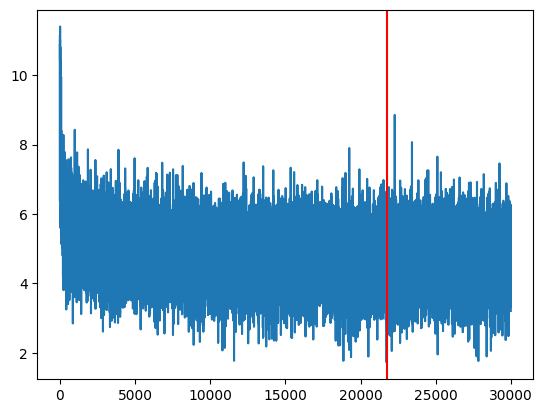

In [480]:
plt.plot(losses);
plt.axvline(losses.argmin(), c = 'r');

In [481]:
flow = equinox.combine(params, static)
best_flow = equinox.combine(best_params, static)

In [482]:
parameters = dict(
    alpha = -2.5,
    m_min = 5,
    m_max = 60,
    d_min = 5,
    d_max = 5,
    mu_m = 35,
    sigma_m = 3,
    f_m = 0.1,
    beta = 0,
    mu_a = 0.1,
    sigma_a = 0.2,
    v_esc = 100_000,
    gamma = 0,
    r_2g = 0.5,
)
# parameters = sample_parameters(jax.random.key(np.random.randint(1e9)))
c = inverse_parameters(parameters)

mergers = sample_mergers(jax.random.key(43), 10_000, parameters)

x = flow.sample(jax.random.key(44), (10_000,), condition = c)
flow_mergers = forward_mergers(x)

x = best_flow.sample(jax.random.key(44), (10_000,), condition = c)
best_flow_mergers = forward_mergers(x)

parameters

{'alpha': -2.5,
 'm_min': 5,
 'm_max': 60,
 'd_min': 5,
 'd_max': 5,
 'mu_m': 35,
 'sigma_m': 3,
 'f_m': 0.1,
 'beta': 0,
 'mu_a': 0.1,
 'sigma_a': 0.2,
 'v_esc': 100000,
 'gamma': 0,
 'r_2g': 0.5}

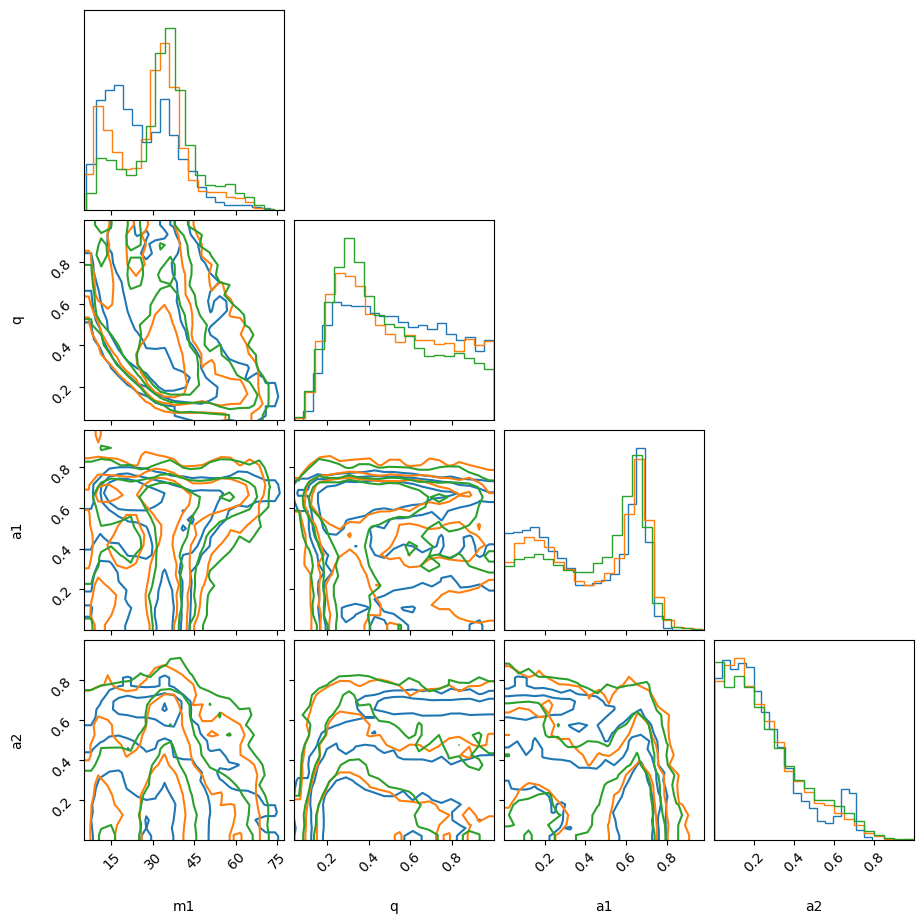

In [483]:
dim = 4
fig = None
for i, samples in enumerate((mergers, flow_mergers, best_flow_mergers)):
    fig = corner(
        np.array(samples), labels = ('m1', 'q', 'a1', 'a2'),
        fig = fig, plot_datapoints = False, plot_density = False,
        plot_contours = True, fill_contours = False, no_fill_contours = True,
        hist_kwargs = dict(density = True, color = f'C{i}'),
        contour_kwargs = dict(colors = [f'C{i}']),
        # range = np.transpose([lo, hi]),
        levels = (0.5, 0.9, 0.99), bins = 20, smooth = 0.5,
    )
for i in range(dim):
    ax = fig.axes[i + dim * i]
    ylim = max(patch.xy[:, 1].max() for patch in ax.patches)
    ax.set_ylim(0, ylim * 1.1)

In [ ]:

bijection = Chain([Sigmoid(shape = (dim,)), Affine(loc = lo, scale = hi - lo)])
bijection = paramax.non_trainable(bijection)